--- 
## 1. Introduction

In this tutorial, we will have a look at the practical side of the Conjugate Gradients method that was introduced this morning. We will explore the general approach and its limitations further, as well as some issues that can arise and how to get around them with preconditioners.

As a small reminder, we want to solve equations of the form

$$
Ax = b,
$$

where $A \in \mathbb{R}^{(n \times n)}$ is a **symmetric** and **positive-definite** matrix. This property allows us to view the problem as a minimization problem, namely

$$
f(x) = \frac 1 2 x^T A x - b^T x,
$$

which is central to the CG method. But let's look at direct methods to this problem first.

### 1.1. Setup

First, we import the necessary libraries. We'll be using `numpy` for numerical operations and `matplotlib` for plotting.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np

# Set up plotting style
plt.style.use("seaborn-v0_8-whitegrid")

### 1.2. Generate an Example Problem

As mentioned before, the CG method requires the matrix $A$ to be symmetric and positive-definite. A simple way to generate such a matrix is to create a random matrix $M$ and compute $A = M^T M$. This construction guarantees that $A$ is symmetric and positive semi-definite. If $M$ is non-singular, $A$ will be positive-definite.

We will set up a linear system $Ax = b$ where we know the true solution `x_true` beforehand. This allows us to easily verify the correctness of our implementations.

In [ ]:
def generate_spd_matrix(n):
    """Generates a symmetric positive-definite matrix of size n x n."""
    M = np.random.rand(n, n)
    # Ensure M is well-conditioned enough to be non-singular
    M += np.eye(n)
    A = M.T @ M
    return A


# Define the size of our problem. Feel free to try a few different values during the course of this exercise.
n = 1000

A = generate_spd_matrix(n)
x_true = np.random.rand(n)

# Calculate the right-hand side b
b = A @ x_true

print(
    f"Generated a {A.shape[0]}x{A.shape[1]} symmetric, positive-definite matrix A and vector b."
)

Generated a 1000x1000 symmetric, positive-definite matrix A and vector b.


### 1.3. The "Naive" Approach: Direct Solver

Before diving into iterative methods, let's solve the system using a standard direct solver from NumPy, `np.linalg.solve`. This function typically uses an LU decomposition, which is very accurate and robust for small to moderately sized dense matrices.

In [30]:
print("Solving Ax = b using the direct method (np.linalg.solve)...")

# Time the direct solver
start_time = time.time()
x_naive = np.linalg.solve(A, b)
end_time = time.time()

time_naive = end_time - start_time

# Check the error
error_naive = np.linalg.norm(x_naive - x_true) / np.linalg.norm(x_true)

print(f"Direct solver finished in {time_naive:.4f} seconds.")
print(f"Relative error of the solution: {error_naive:.2e}")

Solving Ax = b using the direct method (np.linalg.solve)...
Direct solver finished in 0.0204 seconds.
Relative error of the solution: 1.03e-07


This gives us a baseline for both speed and accuracy. For a 1000x1000 matrix, the direct solver should be quite fast, but as we scale up, its computational cost ($O(n^3)$) and memory requirements ($O(n^2)$) will become significant.

### 1.4. The Idea behind the Conjugate Gradient Method

The CG method combines the concept of **steepest descent** with **Krylow subspaces**:

First, we start at some initial point $x_0$, and take a step in the direction of steepest descent.

- This step takes place in the first, one-dimensional Krylow-subspace
- Ideally, this step takes us the optimal amount of length along that direction

Then, for each further step, we find the new direction of maximum descent, but we *only consider directions that do not undo previous progress*

- This means that the steps are $A$-conjugate, instead of merely being orthogonal
- The dimension of the Krylow-subspace increases with each step, so we require at most $n$ steps

This approach gives us the exact solution after at most $n$ steps, if we have perfect arithmetic. While we cannot assume this in practice, much fewer steps can give a good approximation.

### 1.5. The Conjugate Gradient Algorithm (Pseudo-code)

Now let's look at the algorithm we want to implement. The goal is to find $x$ that minimizes $\frac{1}{2}x^T A x - x^T b$.

Given the system $Ax=b$, an initial guess $x_0$, a tolerance `tol`, and a maximum number of iterations `max_iter`:

1.  **Initialize**
    -   $r_0 = b - Ax_0$
    -   $p_0 = r_0$
    -   $k = 0$

2.  **Iterate** while $k < \text{maxiter}$ and $\|r_k\| > \text{tol}$:
    -   $\alpha_k = \frac{r_k^T r_k}{p_k^T A p_k}$
    -   $x_{k+1} = x_k + \alpha_k p_k$
    -   $r_{k+1} = r_k - \alpha_k A p_k$
    -   $\beta_k = \frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$
    -   $p_{k+1} = r_{k+1} + \beta_k p_k$
    -   $k = k + 1$

3. **Return** $x_k$

**Key variables:**
- `x`: The solution vector, which we are improving in each step.
- `r`: The residual vector ($r = b - Ax$), which we can use to compute the current error.
- `p`: The search direction vector. Note that we always move along the residual, here we choose special "$A$-orthogonal" directions.
- `alpha`: The step size.
- `beta`: The improvement factor for the next search direction.

--- 
## 2. Exercise: CG Implementation

### 2.1. Implementing the Algorithm

Now it's your turn! Fill in the missing lines in the `conjugate_gradient` function below. Follow the pseudo-code from the previous section. 

**Hint:** The term $r_k^T r_k$ appears multiple times. It's efficient to compute it once per iteration and reuse the value.

In [ ]:
def conjugate_gradient(A, b, x0=None, tol=1e-6, max_iter=1000):
    """
    Solves the system Ax = b using the Conjugate Gradient method.

    Args:
        A (np.ndarray): The n x n symmetric positive-definite matrix.
        b (np.ndarray): The n x 1 right-hand side vector.
        x0 (np.ndarray, optional): Initial guess for the solution. Defaults to a zero vector.
        tol (float, optional): The tolerance for convergence.
        max_iter (int, optional): The maximum number of iterations.

    Returns:
        tuple: A tuple containing:
            - x (np.ndarray): The solution vector.
            - residuals (list): A list of the residual norm at each iteration.
    """
    n = len(b)

    # Initialize solution vector x
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # ---- Initialize r, p, and rs_old ---- #
    # r is the residual (b - A*x)
    # p is the search direction (initially same as r)
    # rs_old is the dot product of the residual with itself (r^T * r)
    r = b - (A @ x)
    p = r.copy()
    rs_old = r.T @ r
    # -------------------------------------------- #

    residuals = [np.sqrt(rs_old)]

    if residuals[0] < tol:
        print("Initial guess is already within tolerance.")
        return x, residuals

    for i in range(max_iter):
        # ---- Main CG iteration steps ---- #

        # 1. Calculate Ap = A * p
        Ap = A @ p

        # 2. Calculate step size alpha
        alpha = rs_old / (p.T @ Ap)

        # 3. Update solution: x_{k+1} = x_k + alpha * p_k
        x = x + alpha * p

        # 4. Update residual: r_{k+1} = r_k - alpha * Ap
        r = r - alpha * Ap

        # 5. Calculate new residual norm squared
        rs_new = r.T @ r

        # ------------------------------------- #

        # Check for convergence
        residual_norm = np.sqrt(rs_new)
        residuals.append(residual_norm)
        if residual_norm < tol:
            print(f"Converged after {i + 1} iterations.")
            break

        # ---- Update search direction ---- #
        # p_{k+1} = r_{k+1} + (rs_new / rs_old) * p_k
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
        # ------------------------------------- #
    else:
        print(f"Did not converge within {max_iter} iterations.")

    return x, residuals

### 2.2. Test your Implementation

Let's run your implementation, check that it works, and see how it performs compared to the direct solver.

**Don't worry if the code does not seem to converge**, it is quite possible that you will have errors around e-2, even if you implemented everything correctly.

In [ ]:
# Play around with n and tol a little and see what happens
n = 600
tol = 1.0e-6

A = generate_spd_matrix(n)

# As a sanity-check, you can also see if your code converges in the trivial case of A = Id
# A = np.eye(n)

x_true = np.random.rand(n)

# Calculate the right-hand side b
b = A @ x_true

print(
    f"Generated a {A.shape[0]}x{A.shape[1]} symmetric, positive-definite matrix A and vector b."
)

Generated a 600x600 symmetric, positive-definite matrix A and vector b.


In [33]:
# (Optional): Run the naive solver again, for time comparisons
print("Solving Ax = b using the direct method (np.linalg.solve)...")

# Time the direct solver
start_time = time.time()
x_naive = np.linalg.solve(A, b)
end_time = time.time()

time_naive = end_time - start_time

# Check the error
error_naive = np.linalg.norm(x_naive - x_true) / np.linalg.norm(x_true)

print(f"Direct solver finished in {time_naive:.4f} seconds.")
print(f"Relative error of the solution: {error_naive:.2e}")

Solving Ax = b using the direct method (np.linalg.solve)...
Direct solver finished in 0.0042 seconds.
Relative error of the solution: 5.61e-09


In [34]:
print("Solving Ax = b using our own CG implementation...")

# Time the CG solver
start_time = time.time()
x_cg, residuals_cg = conjugate_gradient(A, b, tol=tol, max_iter=n)
end_time = time.time()

time_cg = end_time - start_time

# Check the error
error_cg = np.linalg.norm(x_cg - x_true) / np.linalg.norm(x_true)

print(f"\nCG solver finished in {time_cg:.4f} seconds.")
print(f"Relative error of the solution: {error_cg:.2e}")
print(f"Final residual norm: {residuals_cg[-1]:.2e}")

print(f"\n--- Comparison so far ---")
print(f"Direct solver time: {time_naive:.4f} s")
print(f"Simple CG time:     {time_cg:.4f} s")

Solving Ax = b using our own CG implementation...
Did not converge within 600 iterations.

CG solver finished in 0.0376 seconds.
Relative error of the solution: 5.71e-03
Final residual norm: 4.90e-03

--- Comparison so far ---
Direct solver time: 0.0042 s
Simple CG time:     0.0376 s


**What is happening?**

-   Is the result correct? (Compare `error_cg` to `error_naive` from earlier).
-   How does the computation time compare?
-   How many iterations did it take to converge? Did it converge at all?

Let's plot the convergence history to see how the residual norm decreases over time.

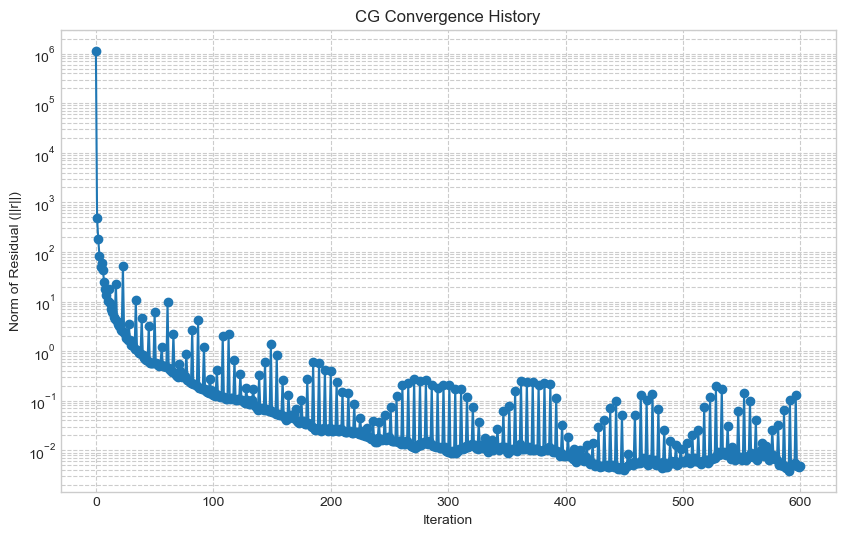

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogy(residuals_cg, marker="o", linestyle="-")
plt.title("CG Convergence History")
plt.xlabel("Iteration")
plt.ylabel("Norm of Residual (||r||)")
plt.grid(True, which="both", ls="--")
plt.show()

You will probably notice some things with your implementation:

1. The direct solver is usually way faster:

- For one, CG's strength lies in very large and/or sparse matrices.
- Even more importantly, the CG method often converges in much fewer than the $n$ steps in practice
- As long as our implementation does not converge at most of the time, it is nowhere near as efficient as it could be! 

2. For any non-trivial example ($n > 10$) and reasonable error tolerances, the algorithm may not converge: You can see in the plot, that the method has a hard time getting below an error tolerance of 1.e-2.
3. The algorithm is not guaranteed to converge after $n$ steps (you can check this by setting `max-iter` to a value higher than `n`): Again, this is due to the lack of perfectly accurate arithmetic.

As you can see, the method is a lot worse than we would have hoped. In the second part of this exercise, we will take a look at preconditioners to speed up convergence and improve these results.

### Bonus exercise

If you are finished before the break, have a think about how we could verify our assumption, before implementing preconditioning. Are there some easy ways to modify the construction of $A$ (i.e. our `generate_spd_matrix` method) to make sure it is well-conditioned?

*Answer: By increasing the factor in `M += np.eye(n)` to e.g. `M += 100 * np.eye(n)`, we can make the matrix diagonally dominant. This gives us a well-conditioned matrix, that our simple algorithm should be able to handle well. However, this is only helpful for demonstration purposes, if we really want to solve an ill-conditioned system, we need to go about it in a different way.*

--- 
## 3. Preconditioning

### 3.1. The Condition Number

The number of iterations CG takes to converge is closely related to the **condition number** of the matrix $A$, denoted $\kappa(A)$.

$\kappa(A) = \|A\| \|A^{-1}\| = \frac{\lambda_{\max}}{\lambda_{\min}}$ (for symmetric positive-definite matrices)

A **high condition number** means the matrix is "ill-conditioned". This has two major negative effects:
1.  **Error Amplification:** Small errors in the input `b` can lead to large errors in the output `x`.
2.  **Slow Convergence:** Iterative methods like CG converge very slowly. The number of iterations is roughly proportional to $\sqrt{\kappa(A)}$.

Let's check the condition number of our matrix `A`.

In [36]:
# Try this with different sizes of A
cond_A = np.linalg.cond(A)
print(f"The condition number of A is: {cond_A:.2e}")

The condition number of A is: 2.51e+09


That's a pretty large number! This explains why our simple CG implementation might have taken many iterations to converge. To fix this, we can use **preconditioning**.

### 3.2. Preconditioning Theory

The idea is to find a **preconditioner matrix** that is:
1.  Also symmetric and positive-definite.
2.  A good approximation of $A$.
3.  Easy to invert.

Instead of solving $Ax=b$, we solve a modified system. The most common form is **left preconditioning**, where we solve $P^{-1}Ax = P^{-1}b$. 

**Note:** Even if $A$ and $P$ are symmetric, the new system matrix $M = P^{-1}A$ is generally not symmetric! This means we cannot apply the standard CG algorithm directly to it. The **Preconditioned Conjugate Gradient** method is a clever variant that is mathematically equivalent to running CG on a transformed, symmetric system, without having to explicitly form $M$.

Our goal is to find a $P$ such that $\kappa(P^{-1}A) \ll \kappa(A)$.

The simplest (but often effective) preconditioner is the **Jacobi Preconditioner** (or Diagonal Preconditioner). We choose $P$ to be the diagonal of $A$.

$P = \text{diag}(A_{11}, A_{22}, ..., A_{nn})$

Since $A$ is symmetric positive-definite, all its diagonal entries $A_{ii}$ are positive, which means $P$ is also positive-definite. Inverting this $P$ is also trivial, as $P^{-1}$ is just a diagonal matrix with entries $1/A_{ii}$.

### 3.3. Implementing the Jacobi Preconditioner

For this part, we will first modify our matrix to generate a new, ill-conditioned matrix that work well with Jacobi preconditioning.

In [ ]:
# A = np.array([[-1, 2, 3], [3, -4, 5], [-6, 7, 8]])
# print(A)
# print(np.abs(np.diag(A)))
# print(np.sum(np.abs(A), axis=1))
# print(np.logspace(0, np.log10(1e10), 5))
# ?np.fill_diagonal

In [ ]:
def make_diagonally_dominant(A, diag_cond_num=1e15):
    n = A.shape[0]
    row_sums = np.sum(np.abs(A), axis=1) - np.abs(np.diag(A))
    ill_conditioned_part = np.logspace(0, np.log10(diag_cond_num), n)
    np.random.shuffle(ill_conditioned_part)
    final_diag = ill_conditioned_part + row_sums
    np.fill_diagonal(A, final_diag)
    return

In [39]:
make_diagonally_dominant(A)
cond_A = np.linalg.cond(A)
print(f"The condition number of A is now: {cond_A:.2e}")

x_true = np.random.rand(n)
b = A @ x_true

The condition number of A is now: 1.18e+10


As for the obvious question: Why bother? The Jacobi preconditioner works well for ill-conditioned, but diagonally dominant matrices, where the main source of issues comes from the diagonal. So this modification is only for demonstrative purposes, but we will get back to the original matrix later.

Let's now create our preconditioner. We will actually compute its inverse, since that's what the algorithm needs.

In [ ]:
# Example of np.diag
matrix = np.array([[1, 2, 3], [3, 4, 5], [5, 6, 8]])
print(1 / np.diag(matrix))
print(np.diag(np.diag(matrix)))
print(np.diag(1 / (np.diag(matrix))))

[1.    0.25  0.125]
[[1 0 0]
 [0 4 0]
 [0 0 8]]
[[1.    0.    0.   ]
 [0.    0.25  0.   ]
 [0.    0.    0.125]]


In [ ]:
# TODO: Create the inverse of the Jacobi preconditioner, P_inv.
# P is a diagonal matrix containing the diagonal of A.
# P_inv is a diagonal matrix containing the reciprocal of the diagonal of A.
# HINT: There is a function called np.diag()
P_inv = np.diag(1 / (np.diag(A)))

# Let's check the condition number of the preconditioned system
cond_PA = np.linalg.cond(P_inv @ A)

print("--- Condition Numbers ---")
print(f"Original matrix A:      {cond_A:.2e}")
print(f"Preconditioned P_inv*A: {cond_PA:.2e}")
print(f"Improvement factor:     {cond_A / cond_PA:.2e} times better")

--- Condition Numbers ---
Original matrix A:      1.18e+10
Preconditioned P_inv*A: 1.60e+00
Improvement factor:     7.37e+09 times better


As you can see, the condition number has been significantly reduced! This should lead to much faster convergence.

### 3.4. The Preconditioned Conjugate Gradients Algorithm

The algorithm is slightly modified to include the preconditioner. The key step is to solve the system $Pz_k = r_k$ for $z_k$ (which is easy since we have $P^{-1}$).

1.  **Initialize**
    -   $r_0 = b - Ax_0$
    -   Solve $Pz_0 = r_0$ (i.e., $z_0 = P^{-1}r_0$)
    -   $p_0 = z_0$
    -   $k = 0$

2.  **Iterate**:
    -   $\alpha_k = \frac{r_k^T z_k}{p_k^T A p_k}$
    -   $x_{k+1} = x_k + \alpha_k p_k$
    -   $r_{k+1} = r_k - \alpha_k A p_k$
    -   Check for convergence on $|r_{k+1}|$
    -   Solve $Pz_{k+1} = r_{k+1}$
    -   $\beta_k = \frac{r_{k+1}^T z_{k+1}}{r_k^T z_k}$
    -   $p_{k+1} = z_{k+1} + \beta_k p_k$

Now, implement the PCG algorithm below.

In [ ]:
def preconditioned_conjugate_gradient(A, b, P_inv, x0=None, tol=1e-6, max_iter=1000):
    """
    Solves the system Ax = b using the Preconditioned Conjugate Gradient method.
    """
    n = len(b)

    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    residuals = []

    # ---- TODO: Initialize r, z, p, and rz_old ---- #
    r = b - (A @ x)
    residuals.append(np.linalg.norm(r))
    if residuals[0] < tol:
        return x, residuals

    # z is the result of applying the preconditioner to r
    z = P_inv @ r

    # p is the search direction
    p = z.copy()  # YOUR CODE HERE

    # rz_old is the dot product of r and z
    rz_old = r.T @ z
    # ----------------------------------------------- #

    for i in range(max_iter):
        # ---- TODO: Main PCG iteration steps ---- #

        # 1. Calculate Ap = A * p
        Ap = A @ p

        # 2. Calculate step size alpha
        alpha = rz_old / (p.T @ Ap)

        # 3. Update solution: x_{k+1} = x_k + alpha * p_k
        x = x + alpha * p

        # 4. Update residual: r_{k+1} = r_k - alpha * Ap
        r = r - alpha * Ap

        # Check for convergence
        residual_norm = np.linalg.norm(r)
        residuals.append(residual_norm)
        if residual_norm < tol:
            print(f"Converged after {i + 1} iterations.")
            break

        # 5. Apply preconditioner for the next step
        z = P_inv @ r

        # 6. Calculate rz_new
        rz_new = r.T @ z

        # 7. Update search direction
        p = z + (rz_new / rz_old) * p
        rz_old = rz_new
        # -------------------------------------- #
    else:
        print(f"Did not converge within {max_iter} iterations.")

    return x, residuals

### 3.5. Testing the PCG Algorithm

Let's run our new PCG implementation and see the difference.

In [52]:
# (Optional): Run the naive solver again, for time comparisons
print("Solving Ax = b using the direct method (np.linalg.solve)...")

# Time the direct solver
start_time = time.time()
x_naive = np.linalg.solve(A, b)
end_time = time.time()

time_naive = end_time - start_time

# Check the error
error_naive = np.linalg.norm(x_naive - x_true) / np.linalg.norm(x_true)

print("Solving Ax = b using our own CG implementation...")

# Time the CG solver
start_time = time.time()
x_cg, residuals_cg = conjugate_gradient(A, b, tol=tol, max_iter=n)
end_time = time.time()

time_cg = end_time - start_time

# Check the error
error_cg = np.linalg.norm(x_cg - x_true) / np.linalg.norm(x_true)

Solving Ax = b using the direct method (np.linalg.solve)...
Solving Ax = b using our own CG implementation...
Did not converge within 600 iterations.


In [53]:
print("Solving Ax = b using our own PCG implementation...")

# Time the PCG solver
start_time = time.time()
x_pcg, residuals_pcg = preconditioned_conjugate_gradient(A, b, P_inv, max_iter=n)
end_time = time.time()

time_pcg = end_time - start_time

# Check the error
error_pcg = np.linalg.norm(x_pcg - x_true) / np.linalg.norm(x_true)

print(f"\nPCG solver finished in {time_pcg:.4f} seconds.")
print(f"Relative error of the solution: {error_pcg:.2e}")
print(f"Final residual norm: {residuals_pcg[-1]:.2e}")

print(f"\n--- Comparison times ---")
print(f"Direct solver time: {time_naive:.4f} s")
print(f"Simple CG time:     {time_cg:.4f} s")
print(f"PCG time:           {time_pcg:.4f} s")

print(f"\n--- Comparison errors ---")
print(f"Direct solver error: {error_naive:.2e}")
print(f"Simple CG error:     {error_cg:.2e}")
print(f"PCG error:           {error_pcg:.2e}")

Solving Ax = b using our own PCG implementation...
Converged after 6 iterations.

PCG solver finished in 0.0017 seconds.
Relative error of the solution: 7.26e-16
Final residual norm: 7.09e-10

--- Comparison times ---
Direct solver time: 0.0050 s
Simple CG time:     0.0380 s
PCG time:           0.0017 s

--- Comparison errors ---
Direct solver error: 1.35e-15
Simple CG error:     7.56e-01
PCG error:           7.26e-16


As we can see, the improvement is dramatic and the new algorithm converges after only a handful of steps. Of course, this particular example is designed to show drastic effects, and it will typically not go quite as well in practice, but you get the idea.

### Open-ended exercise: Explore the limitations of the methods we implemented

- Just like the first part, take some time to try different values or matrices, and get a feel for the limitations of the algorithm
- What happens, if you go back to the first type of matrices that we used, and apply the Jacobi preconditioner?
    - Does the result improve?
    - What may be the reason for its behaviour?
    - What might a suitable preconditioner for this type of matrix look like?
- What happens if you try to apply the CG method to a fully random matrix?
- You could also try to come up with other kinds of matrix and see where the Jacobi preconditioner starts to fail

---

## Outlook

As you've seen in this exercise, the CG method can be a very elegant and efficient approach to solving many issues, *if they have the right properties*. But just as there were many cases, where it brought about a significant performance benefit, there are also many situations, where it is either unsuitable, or the preconditioner needs to be carefully chosen.

Always keep in mind: Just because you have a hammer, not every problem is a nail.

If you are interested in further reading, you can move on to more advanced topics, such as:

- GMRES: The Generalized Minimal Residual applies the ideas of CG in a more general setting. It is on of the standard approaches if you are faced with a non-symmetric matrix $A$. It comes with some drawbacks such as increased memory requirements, though.
- Other preconditioners: There are a multitude of preconditioners, and the best choice always depends on the problem you work with. Typical ones include
    - Gauss-Seidel: It uses the lower triangular part of $A$, and is relatively difficult to parallelize
    - (Symmetric) Succesive Over-Relaxation (SORR): This method is based on Gauss-Seidel, but slightly more involved.